# Siamese Network

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.layers import Dense, Conv2D, Activation, Input, Flatten, Dropout, Lambda, BatchNormalization, Activation
from keras.layers import MaxPooling2D
from keras.optimizers import RMSprop
from keras.datasets import fashion_mnist
from keras.utils.vis_utils import plot_model

# Setting up gpu
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices[0])
tf.config.experimental.set_memory_growth(physical_devices[0], True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
def make_pairs(images, label_indices):
    pairs = []
    labels = []
    classes = len(label_indices)
    n = np.min([len(label_indices[i]) for i in range(classes)])
    
    for c in range(classes):
        for i in range(n - 1):
            # Adding positive pair (similar)
            inx_1, inx_2 = label_indices[c][i], label_indices[c][i + 1]
            pairs += [[images[inx_1], images[inx_2]]]
    
            # Adding negative pair (not similar)
            addition = np.random.randint(1, classes)
            new_c = (c + addition) % classes
            inx_1, inx_2 = label_indices[c][i], label_indices[new_c][i]
            pairs += [[images[inx_1], images[inx_2]]]
    
            # Adding labels
            labels += [1, 0]

    return np.array(pairs), np.array(labels)


def create_pair_on_set(images, labels):
    label_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, new_labels = make_pairs(images, label_indices)
    new_labels = new_labels.astype(np.float32)
    return pairs, new_labels

## Load the data

In [4]:
def normalization(x, y):
    mu = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    return (x - mu) / std, y

In [5]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')
train_images = train_images / 255.0
test_images = test_images / 255.0
input_shape = (28, 28, )

tr_pairs, tr_labels = create_pair_on_set(train_images, train_labels)
te_pairs, te_labels = create_pair_on_set(test_images, test_labels)

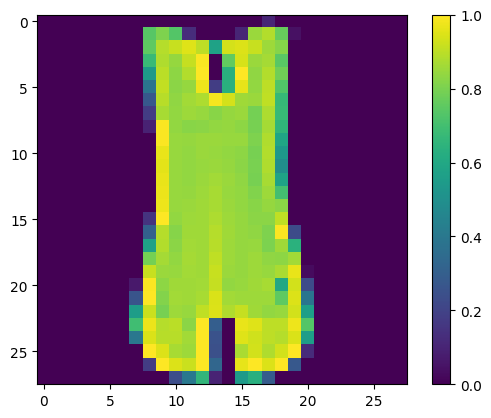

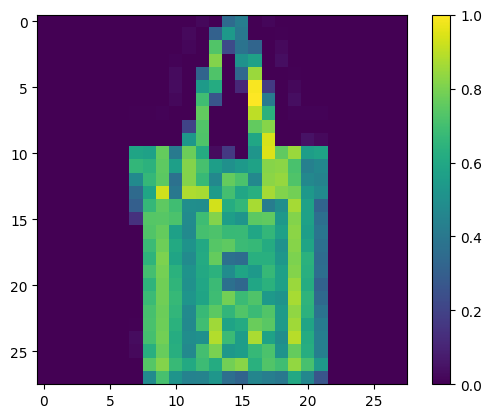

0.0 >> "one" shows if they are similar and "zero" shows they are not similar


In [6]:
def showimage(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

pair_index = 5
pair_1 = tr_pairs[pair_index][0]
pair_2 = tr_pairs[pair_index][1]
showimage(pair_1)
showimage(pair_2)
print(f'{tr_labels[pair_index]} >> "one" shows if they are similar and "zero" shows they are not similar')

## Creating the model

In [19]:
def initialize_base_model(input_shape):
    input = Input(shape=input_shape, name='base_input')
    X = Lambda(lambda x: tf.reshape(x, (-1, ) + input_shape + (1,)))(input)
    
    X = Conv2D(filters=128, kernel_size=3, padding='same', name='conv1')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X, training=True)
    X = Activation('relu', name='relu1')(X)
    X = MaxPooling2D(name='maxpool1')(X)

    X = Conv2D(filters=128, kernel_size=3, padding='same', name='conv2')(X)
    X = BatchNormalization(axis=-1, name='bn2')(X, training=True)
    X = Activation('relu', name='relu2')(X)
    X = MaxPooling2D(name='maxpool2')(X)

    X = Conv2D(filters=128, kernel_size=3, padding='same', name='conv3')(X)
    X = BatchNormalization(axis=-1, name='bn3')(X, training=True)
    X = Activation('relu', name='relu3')(X)
    X = MaxPooling2D(name='maxpool3')(X)

    X = Flatten(name='flatten_input')(X)
    X = Dropout(0.2, name='dropout1')(X)
    X = Dense(units=128, name='dense1')(X)
    X = Activation('relu', name='relu4')(X)
    X = Dropout(0.2, name='dropout2')(X)
    X = Dense(units=128, name='dense2')(X)
    X = Activation('relu', name='relu5')(X)
    X = Dropout(0.2, name='dropout3')(X)
    X = Dense(units=128, name='dense3')(X)
    X = Activation('relu', name='relu6')(X)

    return keras.Model(inputs=input, outputs=X)

In [20]:
def euclidean_distance(vects):
    x_1, x_2 = vects
    squared_sum = tf.reduce_sum(tf.square(x_1 - x_2), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(squared_sum, 1e-8))

def euc_dist_output_shape(shapes):
    shape_1, shape_2 = shapes
    return (shape_1[0], 1)

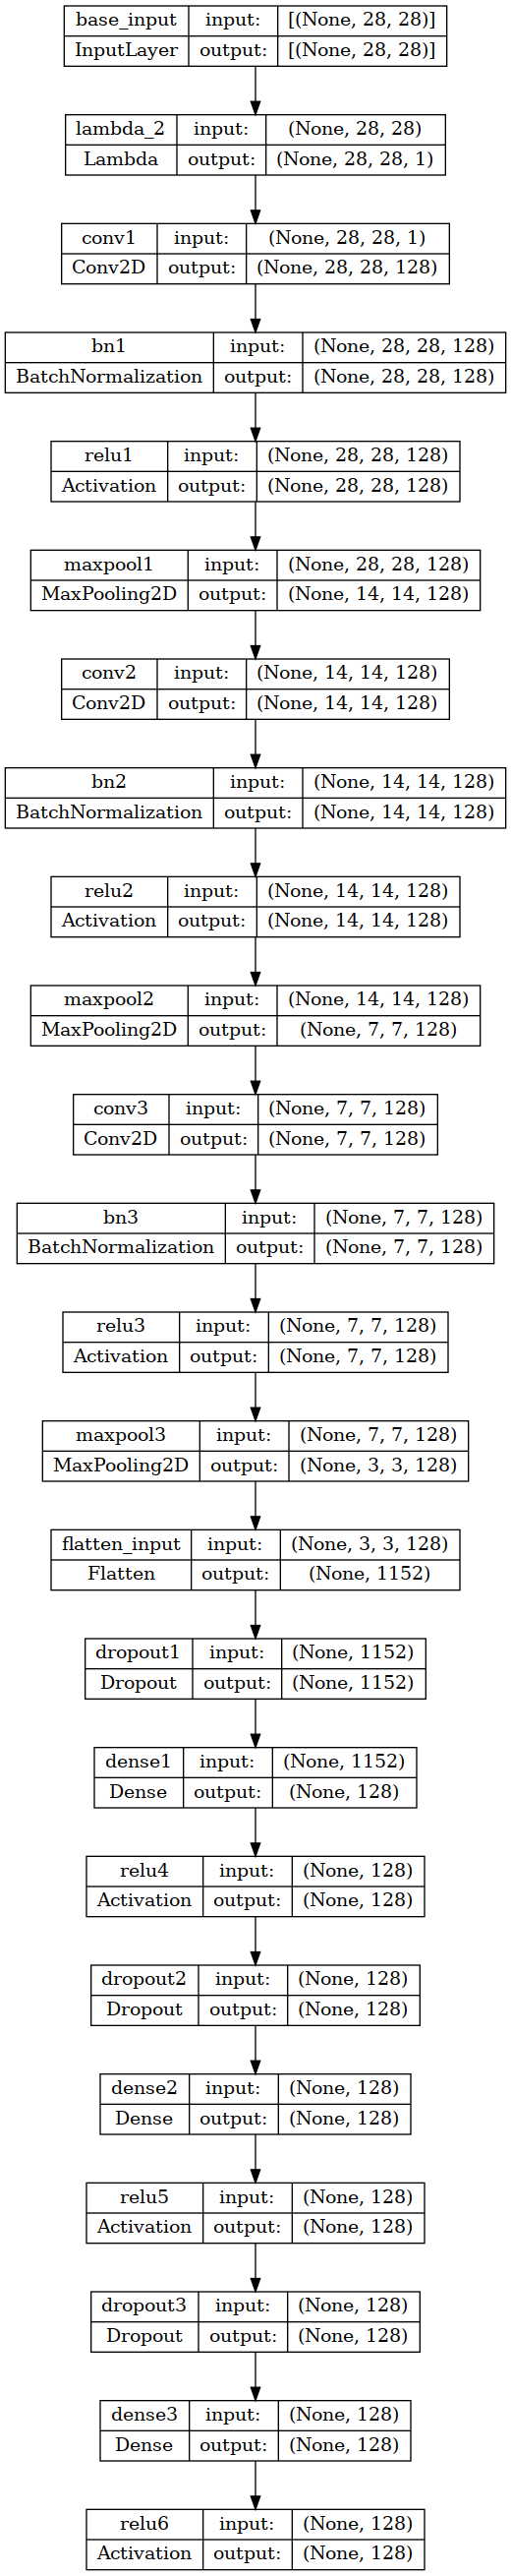

In [21]:
base_model = initialize_base_model(input_shape=input_shape)
plot_model(base_model, show_shapes=True, show_layer_names=True, to_file='base_model.png')

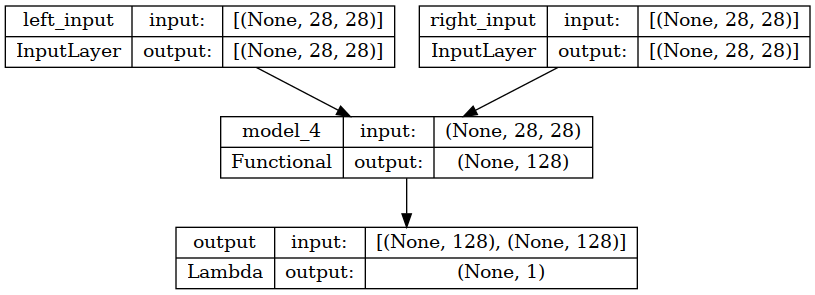

In [22]:
input_a = Input(shape=input_shape, name='left_input')
output_vector_a = base_model(input_a)

input_b = Input(shape=input_shape, name='right_input')
output_vector_b = base_model(input_b)

output = Lambda(euclidean_distance, name='output')([output_vector_a, output_vector_b])
model = keras.Model(inputs=[input_a, input_b], outputs=output)

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [23]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 28, 28)]     0           []                               
                                                                                                  
 right_input (InputLayer)       [(None, 28, 28)]     0           []                               
                                                                                                  
 model_4 (Functional)           (None, 128)          478592      ['left_input[0][0]',             
                                                                  'right_input[0][0]']            
                                                                                                  
 output (Lambda)                (None, 1)            0           ['model_4[0][0]',          

In [24]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        pred_square = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean(pred_square * y_true + (1 - y_true) * margin_square)
    return contrastive_loss

In [ ]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(1), optimizer=rms)
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_labels, epochs=15, batch_size=128, 
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_labels))

Epoch 1/15
938/938 [==============================] - 25s 25ms/step - loss: 0.1787 - val_loss: 0.0940
Epoch 2/15
938/938 [==============================] - 131s 139ms/step - loss: 0.0869 - val_loss: 0.0838
Epoch 3/15
938/938 [==============================] - 141s 150ms/step - loss: 0.0761 - val_loss: 0.0749
Epoch 4/15
938/938 [==============================] - 141s 150ms/step - loss: 0.0697 - val_loss: 0.0719
Epoch 5/15
327/938 [=========>....................] - ETA: 1:26 - loss: 0.0660

In [ ]:
print(model.evaluate([te_pairs[:, 0], te_pairs[:, 1]], te_labels))

In [ ]:
def accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [ ]:
te_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]], verbose=0)
print(f'{accuracy(te_labels, te_pred) * 100:.2f}% accuracy on test set')

tr_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]], verbose=0)
print(f'{accuracy(tr_labels, tr_pred) * 100:.2f}% accuracy on training set')

In [ ]:
def plot_metric(ax, history, metric_name, ylim):
    ax.plot(history.epoch, history.history[metric_name], label=metric_name)
    ax.plot(history.epoch, history.history['val_' + metric_name], label='val_' + metric_name)
    ax.set_xlabel('epoch')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} per epoch')
    ax.set_ylim([0, ylim])
    ax.grid(True)
    ax.legend();

In [ ]:
fig, ax = plt.subplots()
plot_metric(ax, history, 'loss', 2);

In [ ]:
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize='large', edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')

def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17, 3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, (n, 28, 28))
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, (28, 28 * n))
    plt.imshow(left)
    
    plt.figure(figsize=(17, 3))
    plt.yticks([])
    plt.xticks([28 * x + 14 for x in range(n)], predictions)
    for i, t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red')
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28 * n])
    plt.imshow(right)

In [ ]:
y_pred_train = np.squeeze(tr_pred)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes],
              y_pred_train[indexes], tr_labels[indexes],
              'Images', 10)